# Yankees - Propensity Event- eventDay
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 03, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '54.164.224.129'  
DATABASE = 'stlrRays' 
USERNAME = 'nrad' 
PASSWORD = 'Y34@PSc^n@JAG=4%p8194'#getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 53 # Yankees

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrYankees].[ds].[getPropensityEventScoring_new] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"]) 

CNXN.commit()
cursor.close()

df.shape

(522555, 31)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522555 entries, 0 to 522554
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   lkupClientId                522555 non-null  int64         
 1   dimCustomerMasterId         522555 non-null  int64         
 2   eventName                   522555 non-null  object        
 3   inMarket                    522555 non-null  int64         
 4   year                        522555 non-null  int64         
 5   productGrouping             522555 non-null  object        
 6   Tier                        522555 non-null  int64         
 7   eventDay                    522555 non-null  int64         
 8   totalSpent                  522555 non-null  float64       
 9   recentDate                  522555 non-null  datetime64[ns]
 10  attendancePercent           522555 non-null  float64       
 11  renewedBeforeDays           522555 non-

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["dimCustomerMasterId",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "recency",
        "click_link",
        "fill_out_form",
        "open_email" ,
        "send_email",
        "unsubscribe_email",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio",
        "numWebEngagementActivities",
        "numAppViewsActivities",
        "eventDay",
        "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]
#df_dataset = df_dataset[df_dataset["Tier"] == {1,2,3} ]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (372952, 20)
Unseen Data For Predictions: (65815, 20)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="eventDay", 
    train_size = 0.80,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "recency",
        "click_link",
        "fill_out_form",
        "open_email" ,
        "send_email",
        "unsubscribe_email",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio",
        "numWebEngagementActivities",
        "numAppViewsActivities"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.3423,0.7168,0.3366,0.3628,0.3426,0.2267,0.2287,56.7300


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.3390,0.7155,0.3332,0.3584,0.3389,0.2229,0.2249
1,0.3398,0.7158,0.3347,0.3603,0.3406,0.2239,0.2258
2,0.3459,0.7194,0.3407,0.3659,0.3463,0.2311,0.2331
3,0.3412,0.7153,0.3359,0.3620,0.3421,0.2256,0.2276
4,0.3445,0.7204,0.3390,0.3647,0.3447,0.2294,0.2315
5,0.3434,0.7167,0.3375,0.3649,0.3438,0.2279,0.2300
6,0.3435,0.7187,0.3374,0.3644,0.3434,0.2280,0.2301
7,0.3389,0.7140,0.3328,0.3593,0.3389,0.2226,0.2246
8,0.3423,0.7167,0.3364,0.3624,0.3426,0.2268,0.2287
9,0.3441,0.7158,0.3382,0.3657,0.3444,0.2288,0.2309


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(83788, 31)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,eventName,inMarket,year,productGrouping,Tier,eventDay,totalSpent,recentDate,...,NumberofGamesPerSeason,isNextGameBuyer,Label,Score_1,Score_2,Score_3,Score_4,Score_5,Score_6,Score_7
438767,53,51,20210527 - Toronto Blue Jays,1,2021,Online Individual Game,5,4,32.0,1970-01-01,...,94,0,7,0.0632,0.0979,0.1024,0.0589,0.2269,0.1272,0.3235
438768,53,76,20210401 - Toronto Blue Jays,1,2021,Online Individual Game,1,4,900.0,1970-01-01,...,94,1,6,0.0534,0.0210,0.0395,0.0314,0.0109,0.5996,0.2442
438769,53,360,20210817 - Boston Red Sox,1,2021,Online Individual Game,2,2,150.0,1970-01-01,...,94,0,5,0.1015,0.1210,0.1605,0.1765,0.1895,0.1580,0.0931
438770,53,360,20210903 - Baltimore Orioles,1,2021,Online Individual Game,5,5,0.0,1970-01-01,...,94,0,6,0.0644,0.0934,0.1547,0.0896,0.2021,0.2360,0.1599
438771,53,590,20210819 - Minnesota Twins,1,2021,Online Individual Game,7,4,122.0,1970-01-01,...,94,0,3,0.0470,0.0177,0.4321,0.0141,0.0163,0.3790,0.0937


In [11]:
new_predictions["Label"].value_counts()

7    28148
6    23358
2     9697
3     7563
1     6937
5     6509
4     1576
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    66831
(0.2, 0.4]       15179
(0.4, 0.6]        1351
(0.6, 0.8]         320
(0.8, 1.0]         107
Name: Score_1, dtype: int64

In [13]:
new_predictions["Score_2"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    67667
(0.2, 0.4]       14979
(0.4, 0.6]         949
(0.6, 0.8]         159
(0.8, 1.0]          34
Name: Score_2, dtype: int64

In [14]:
new_predictions["Score_3"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    71814
(0.2, 0.4]       10380
(0.4, 0.6]        1209
(0.6, 0.8]         338
(0.8, 1.0]          47
Name: Score_3, dtype: int64

In [15]:
new_predictions["Score_4"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    81557
(0.2, 0.4]        1727
(0.4, 0.6]         264
(0.6, 0.8]         156
(0.8, 1.0]          84
Name: Score_4, dtype: int64

In [16]:
new_predictions["Score_5"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    73839
(0.2, 0.4]        9699
(0.4, 0.6]         236
(0.6, 0.8]          14
(0.8, 1.0]           0
Name: Score_5, dtype: int64

In [24]:
new_predictions["Score_6"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    48317
(0.2, 0.4]       22582
(0.4, 0.6]        9330
(0.6, 0.8]        3269
(0.8, 1.0]         290
Name: Score_6, dtype: int64

In [25]:
new_predictions["Score_7"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    47464
(0.2, 0.4]       23000
(0.8, 1.0]        5323
(0.4, 0.6]        4718
(0.6, 0.8]        3283
Name: Score_7, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

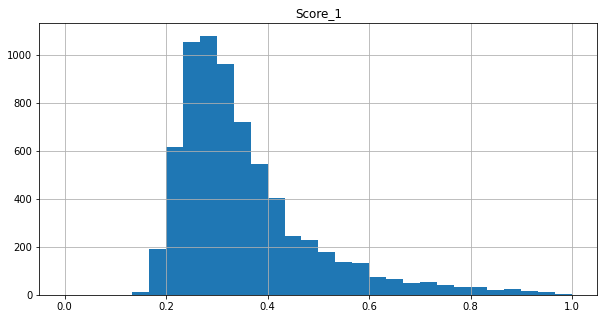

In [17]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_2'}>]], dtype=object)

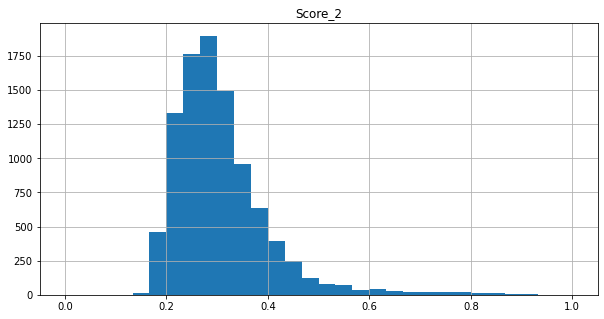

In [18]:
new_predictions[new_predictions["Label"]==2][["Score_2"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_3'}>]], dtype=object)

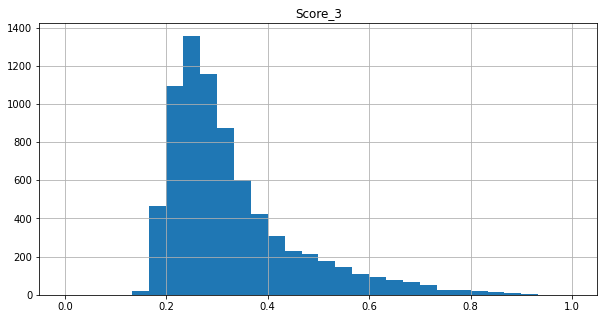

In [19]:
new_predictions[new_predictions["Label"]==3][["Score_3"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_4'}>]], dtype=object)

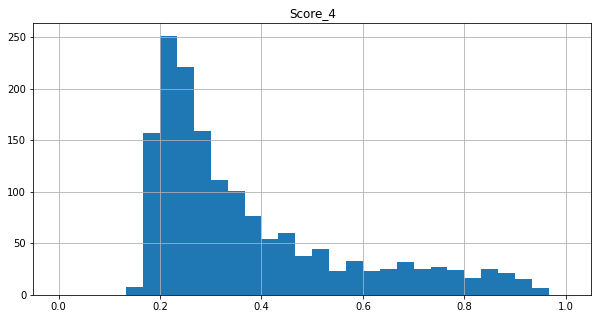

In [20]:
new_predictions[new_predictions["Label"]==4][["Score_4"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_5'}>]], dtype=object)

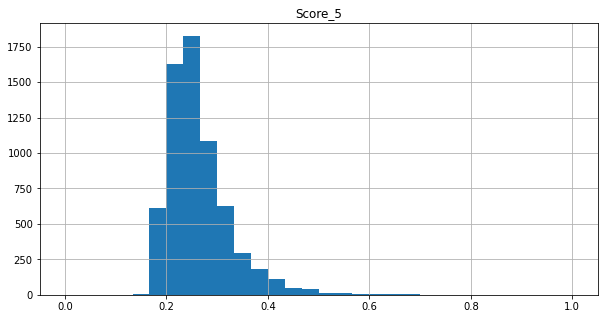

In [21]:
new_predictions[new_predictions["Label"]==5][["Score_5"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_6'}>]], dtype=object)

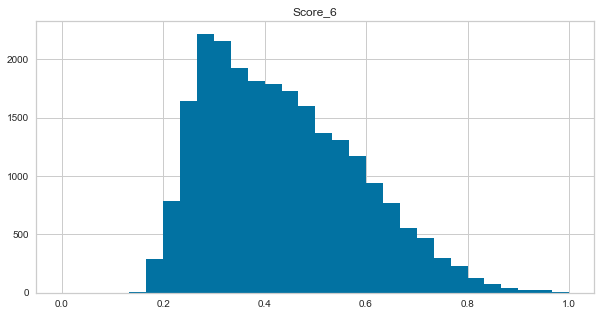

In [26]:
new_predictions[new_predictions["Label"]==6][["Score_6"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_7'}>]], dtype=object)

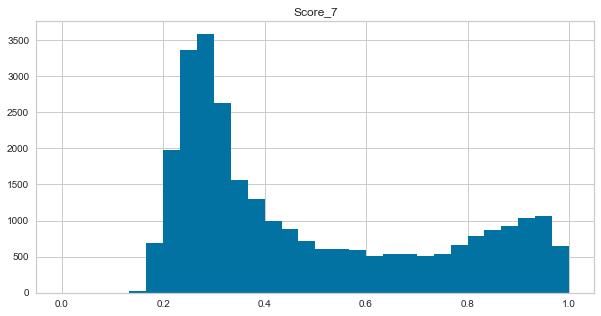

In [27]:
new_predictions[new_predictions["Label"]==7][["Score_7"]].hist(bins=30, figsize=(10,5), range=[0,1])

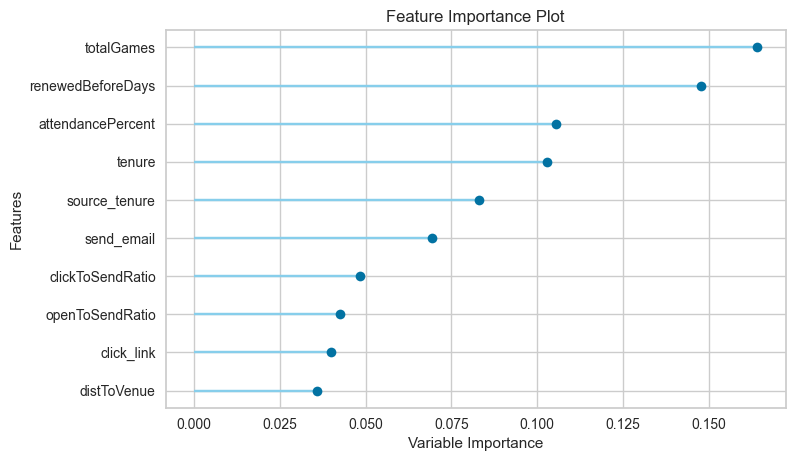

In [22]:
plot_model(best_model, plot='feature')

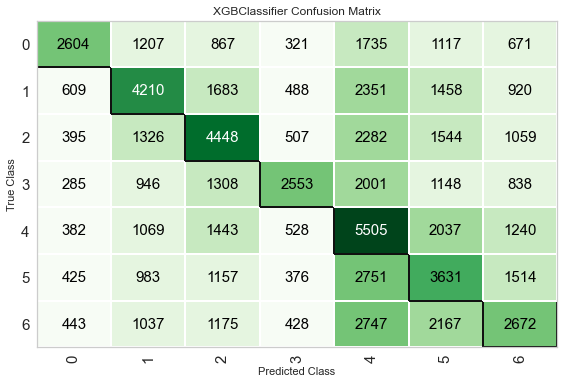

In [23]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?

* We should ask CS/CI what they think the most significant factor towards a next game buyer is.